# Conversion Rate (CR) Prediction Service

The notebook contains EDA, data curation and modeling experimentation

**Objective**: to build model(s) for predicting users conversion rate probality per keyword depending on the device platfrom users employ for a search.

**DoD for the model performance**

MSE to be less then the ones can be obtained done with the following naïve/baseline models:

- predicting 0 for all entities - baseline0
- predicting the mean of the entire train data set - baseline1
- predicting the mean of the train data set by device - baseline2
- predicting the mean of the train data set by entity_id - baseline3

In [2]:
import os
import pandas as pd
import numpy as np
import pandas_profiling
import time
import sklearn
from sklearn.metrics import mean_squared_error as MSE
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline
plt.style.use('ggplot')

np.random.seed(2019)

In [3]:
DIR = os.getcwd()
PATH_DATA = os.path.join(os.path.dirname(DIR), 'bucket/data')
PATH_MODEL = os.path.join(os.path.dirname(DIR), 'bucket/model')

In [13]:
df = pd.read_csv(os.path.join(PATH_DATA, 'raw/technical_test_training_data.csv'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56181 entries, 0 to 56180
Columns: 165 entries, entity_id to Conversions
dtypes: int64(164), object(1)
memory usage: 70.7+ MB


In [ ]:
df.profile_report()

## Data preparation

The "att" features are binary, hense the following dimensionality reduction "trick" can be employed: 

- concatinate "attXX" features values into one long string "attrs" which can be treated as only *one* (instead of 160) binary number describing a keyword
- convert the "attrs" feature to floating point numbers feature
- scale "attrs" floats between 0 and 1

As the result, a keyword *entity_id* is being described by a unique float instead of 160 bool features.

In [14]:
atts_cols = [i for i in df.columns if i.startswith('att')]
attrs = df[atts_cols]
attrs_int = attrs.apply(lambda x: int(''.join(x.astype(str)), 2), axis=1)

In [15]:
df['attrs'] = attrs_int

Now, we have only one feature which identifies a keyword. Let's however confirm that it's being fully identified by the "attrs" feature value and it doesn't depend on e.g. device.

In [7]:
# check how many entity_id with more then one set of "attXX"/"attrs" exist

sum(df.groupby('entity_id').agg(
    cnt_device = pd.NamedAgg('device', lambda x: x.nunique()),
    cnt_weeks = pd.NamedAgg('week', lambda x: x.nunique()),
    cnt_attrs = pd.NamedAgg('attrs', lambda x: x.nunique())
)['cnt_attrs'] > 1)

0

The data set contains the time-series dimension "week". It is however only two weeks of data present and as discussed with Julien, the seasonality prediction is beyond the scope of this problem. On that basis, the "week" columns is being dropped average convesion rate probability is being calculated across combinations of the fetures {entity_id, device, attrs} as 

$$\frac{\sum_{weeks} Conversions}{\sum_{weeks} Clicks}$$

In [16]:
# find CR using above assumption
df = df.groupby([*['entity_id', 'device', 'attrs'], 
                 *atts_cols], as_index=False)[['Clicks', 'Conversions']].sum()

# 1e-15 term in denominator is to avoid "division by 0" error
df['cr'] = df.apply(lambda x: x['Conversions']/(x['Clicks'] + 1e-15), axis=1)

# filter out irrelevant data points with CR > 1
# the number of conversions exceeding number of clicks doesn't make much sense and may be a sign of broken tracking and data quality issue
df = df[df['cr'] <= 1]

# scale the combined attributes feature to be able to handle it
# otherwise numpy won't be able to allocated enough memory (C int size limitation)
# it's an idvised step anyways to avoid overfit to a particular feature due to its absolute value
df['attrs_scale'] = sklearn.preprocessing.minmax_scale(df['attrs'])

# drop columns not in use
df.drop(['Clicks', 'Conversions', 'attrs'], axis=1, inplace=True)

# encode the device column (a sklearn could be used for this either)
df = df.replace({"Computer": 0,
                 "Smartphone": 1,
                 "Tablet": 2})

A generally good practice is, to downcast the data types to reduce RAM consumtion for storage and to optimize training process. This step is advised to use (especially when it comes to floating point data type) to remove unnessesarly precision to reduce computation complexety

In [277]:
from collections import namedtuple
from typing import NamedTuple


def type_downcast(vec: pd.Series) -> pd.Series:
    """Function to downcast data type of the feature
    
    Args:
        vec: pd.Series vector
       
    Returns:
        pd.Series
    """
    _types = namedtuple('types', ['int', 'float'])
    types = _types(int=[f"np.int{i}" for i in [8, 16, 32, 64]],
                   float=[f"np.float{i}" for i in [16, 32, 64, 128]])

    vec_dtype = vec.dtype
    if vec_dtype not in types._fields:
        return vec
    
    col_min = vec.min()
    col_max = vec.max()
    
    for tid, type_class in enumerate(types._fields):
        if vec_dtype != type_class:
            continue
    
        for _type in types[tid]:
            if type_class == 'int':
                type_min, type_max = np.iinfo(eval(_type)).min, np.iinfo(eval(_type)).max
            elif type_class == 'float':
                type_min, type_max = np.finfo(eval(_type)).min, np.finfo(eval(_type)).max
            else:
                break
            if type_min <= col_min <= type_max:
                    return vec.astype(eval(_type), copy=True)

In [278]:
for col in df.columns:
    if (col.startswith('att') is True) or (col in ['cr', 'device']):
        df.loc[:, col] = type_downcast(df[col])

In [19]:
# save preprocessed data
df.to_csv(os.path.join(PATH_DATA, 'processed/data.csv.gz'), index=False)

In [17]:
# let's have a look at the
df.profile_report()

Based on the data set profiling, the following conclusions/observation can be made:

- the target class is unbalanced with only about 20% of data points corresponding to a user conversion
- device type distribution is also skewed with the ratio of classes tablet:smartphone:computer ~ 1:1:2
- the data set has the time-series dimensiton and has two weeks worth of data
- number of features can be potentially reduced by omiting some columns due to their correlation:
    - att2 ~ att6 ~ att28
    - att10 ~ att11 ~ att44
    - att17 ~ att19
    - att9 = att35
    - att4 = att26

## Modeling

In general, it is a decent technique to follow an iterative modelling approach:

identify baseline (business objectives most of the times) -> base features -> simple model -> production -> model preformance improvement iterations until business objectives hit

Model performance can be improved by combining the following options:

- get higher volume of data (number of data points)
- feature engineering (number of features and their correlation to the target/predictor)
- model fine tunining (existing model hyperparameters tuning)
- increase model complexity (switch from simple regressior to ANN, GBM etc.)

### Baseline

Let's check performace of the baseline models noted in problem statement

In [431]:
# baseline models performance

def baseline_mse(d: pd.DataFrame) -> dict:    
    """Function to calculate MSE * 10e5 of the baseline models"""
    # model baseline0
    d['baseline0'] = 0 
    
    # model baseline1
    d['baseline1'] = d['cr'].mean()
    
    # model baseline2
    d = d.merge(d.groupby(['device']).agg(
        baseline2 = pd.NamedAgg('cr', np.mean)
    ), on=['device'])
    
    # model baseline3
    d = d.merge(d.groupby(['entity_id']).agg(
        baseline3 = pd.NamedAgg('cr', np.mean)
    ), on=['entity_id'])
    
    metrics = {
        i: int(MSE(d['cr'], d[i]) * 10e5) for i in [col for col in d.columns
                                            if col.startswith('baseline')]
    }
    
    return metrics

In [433]:
# check metrics across devices for prediction across 

baseline_mse(df.copy())

{'baseline0': 21002, 'baseline1': 19119, 'baseline2': 19027, 'baseline3': 7625}

It is worth mentioning that the *baseline3* model predicts CR per entity_id as it is equal to the averaged CR value across entity_id hanse it is overfitting to an individual data point. Moreover MSE of baseline3 model is skewed towards 0 because about 45% keywords/entity_id values from data sample have only one data point which would correspond to zero error "prediction" done by model3:

In [276]:
datapoints_per_keyword = df.groupby('entity_id', as_index=False)['device'].agg('count')\
                           .groupby('device', as_index=False).agg('count')
datapoints_per_keyword.columns = ['cnt_data_points', 'share']
datapoints_per_keyword.loc[:, 'share'] = datapoints_per_keyword['share']/df['entity_id'].nunique()
datapoints_per_keyword

cnt_data_points     share
0                1  0.457722
1                2  0.253073
2                3  0.289205

On that basis, the mane objective for solution would be to build a model to "beat" *baseline{0-2}* in tearms of MSE.

## Pearson correlation coeffitient

In [273]:
cols = [*['cr', 'device', 'attrs_scale'], *atts_cols]
corr = df[cols].corr()['cr']

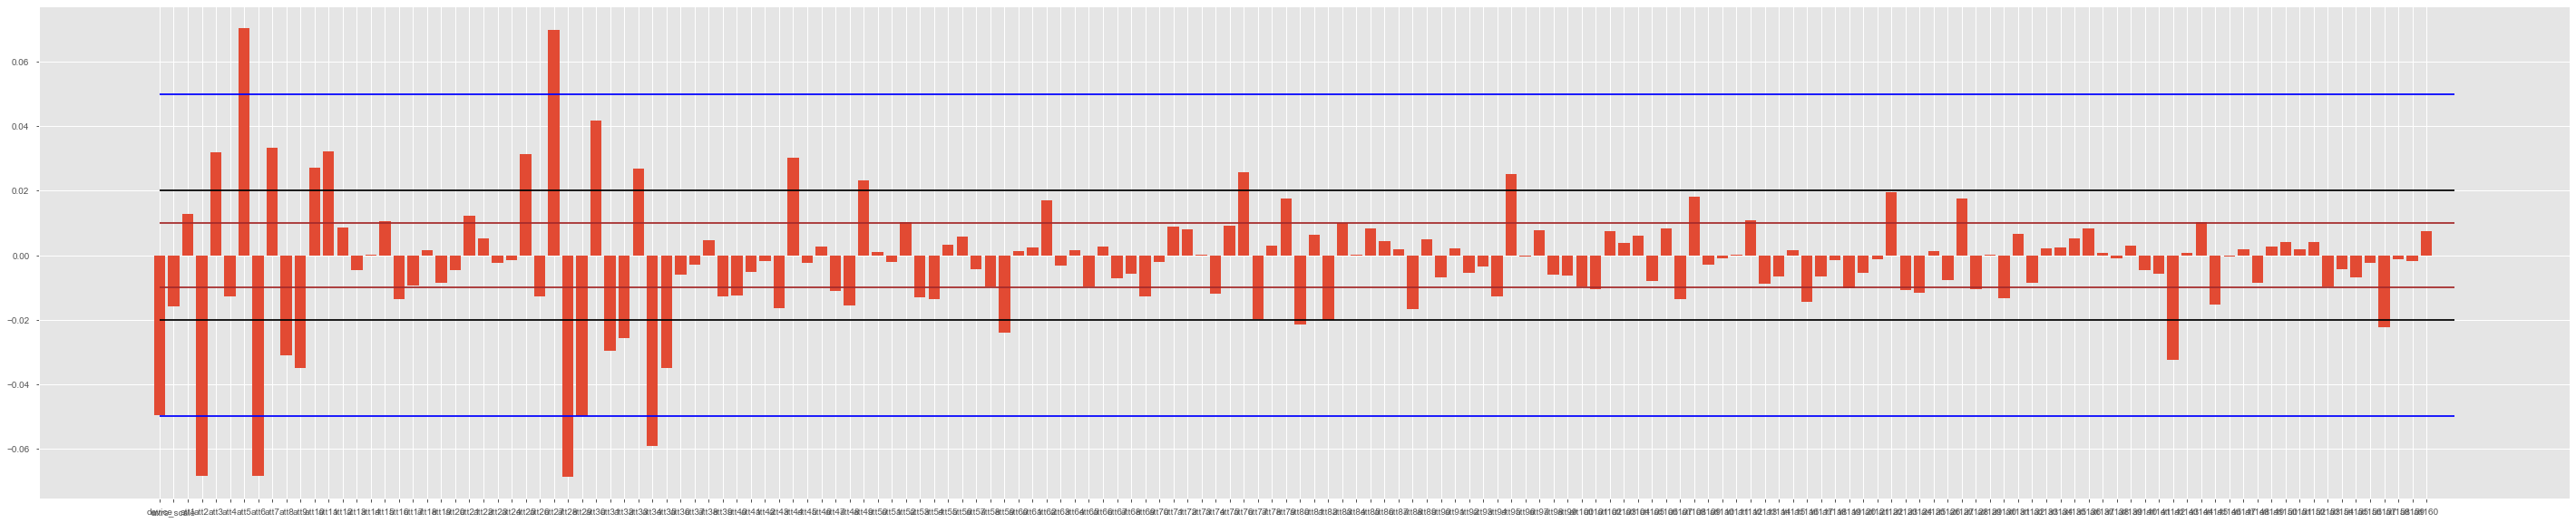

In [274]:
# let's have a look at the Pearson's corr distribution across all features

plt.figure(figsize=(50, 10))
plt.bar(x=[i for i in cols 
           if i != 'cr'],
        height=corr[1:])
plt.hlines(y=[-0.05, 0.05], 
           xmin=0, xmax=len(cols), 
           colors='b')
plt.hlines(y=[-0.02, 0.02], 
           xmin=0, xmax=len(cols), 
           colors='k')
plt.hlines(y=[-0.01, 0.01], 
           xmin=0, xmax=len(cols), 
           colors='brown')
plt.show()

## Feature engineering v1

Train models using the following features:
- device
- attrs_scale
- att6 and att28 to be excluded because they are highly correlated with att2
- att9 used instead of att35 (att35 to be excluded) since they are 100% correlated
- top 10 highly linearly correlated features

In [75]:
features_top10 = [i for i in pd.DataFrame({'corr': corr[1:],
                                           'abs': abs(corr[1:])
                                          }).sort_values(by=['abs'], 
                                                         ascending=False)['corr'].index
                  if i not in ['device', 'att6', 'att28', 'att35']][:10]

In [81]:
# list of features
cols_v1 = [*['cr', 'entity_id', 'device', 'attrs_scale'],
           *features_top10]

In [175]:
df_v1 = df[cols_v1].copy().reset_index(drop=True)

In [183]:
# save v1 data sample
df_v1.to_csv(os.path.join(PATH_DATA, 'processed/data_v1.csv.gz'), index=False)

### Prepare a train/eval data split

In [178]:
train_ids = list(pd.Series(df_v1.index).sample(frac=0.8, random_state=2019))

In [179]:
df_v1_train = (df_v1[df_v1.index.isin(train_ids)].copy()).reset_index(drop=True)
df_v1_eval = (df_v1[~df_v1.index.isin(train_ids)].copy()).reset_index(drop=True)

In [212]:
# save train/eval data sets
df_v1_train.to_csv(os.path.join(PATH_DATA, 'train/v1/train.csv.gz'), index=False)
df_v1_eval.to_csv(os.path.join(PATH_DATA, 'train/v1/eval.csv.gz'), index=False)

### v1 model

Let's start off with linear regressor

In [104]:
from sklearn import linear_model

In [197]:
model_v1 = linear_model.LinearRegression(n_jobs=-1)

In [204]:
model_v1.fit(df_v1_train.drop(['cr', 'entity_id'], axis=1), df_v1_train['cr'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [221]:
def model_mse(model, 
              df_train: pd.DataFrame, 
              df_eval: pd.DataFrame, 
              df_overall: pd.DataFrame, 
              col_lose: []) -> dict:
    """Function to calculate MSE * 10e5 for train/eval/averall datasets
    
    Args:
        model: model to predict CR
        df: DataFrame to predict on
        col_lose: list of colums to drop from features to predict on
    
    Returns:
        dict with MSE value evaluated on tran, evan and overall data sets
    """
    return {
        "train": int(MSE(df_train['cr'], 
                         model.predict(df_train.drop(col_lose, axis=1))) * 10e5),
        "eval": int(MSE(df_eval['cr'], 
                        model.predict(df_eval.drop(col_lose, axis=1))) * 10e5),
        "overall": int(MSE(df_overall['cr'], 
                           model.predict(df_overall.drop(col_lose, axis=1))) * 10e5)
    }

In [211]:
model_mse(model_v1, 
          df_train=df_v1_train,
          df_eval=df_v1_eval,
          df_overall=df_v1,
          col_lose=['cr', 'entity_id'])

{'train': 19031, 'eval': 17941, 'overall': 18813}

In [435]:
# compare to baseline on eval data
baseline_mse(df_v1_eval.copy())

{'baseline0': 20008, 'baseline1': 18240, 'baseline2': 18110, 'baseline3': 1803}

A simple linear regression has a better performance compared to the baseline models. 

Save and deploy the model -> service MVP. Implementation of a service to re-train the model to be done as weel (see README.md for details) 

In [213]:
import pickle

with open(os.path.join(PATH_MODEL, "v1/model.pkl"), 'wb') as f:
    pickle.dump(model_v1, f)

### v2 model

Let's build GBM to improve overall performance and to define features importance

In [290]:
from xgboost import XGBRegressor
import xgboost as xgb
from typing import Any

In [228]:
parameters = {
    "learning_rate": 0.1,
    "n_estimators": 40, 
    "max_depth": 10
}

dropped columns: 
{'train': 18712, 'eval': 17949, 'overall': 18559}
dropped columns: device
{'train': 18967, 'eval': 18117, 'overall': 18797}
dropped columns: attrs_scale
{'train': 18835, 'eval': 17961, 'overall': 18660}
dropped columns: device, attrs_scale
{'train': 19055, 'eval': 18108, 'overall': 18865}


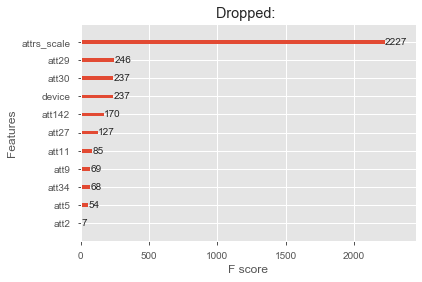

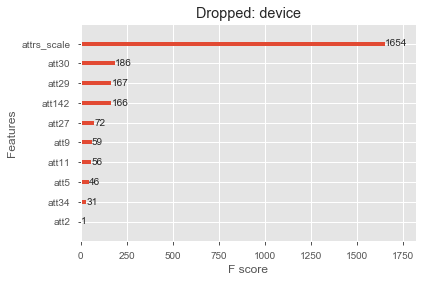

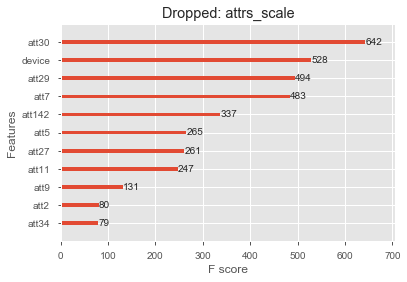

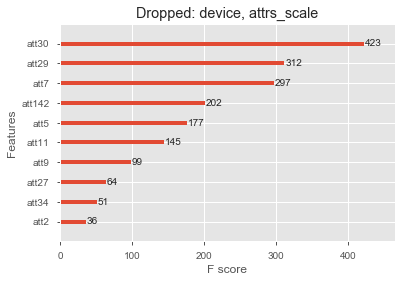

In [222]:
# check the features importance by dropping additional

cols_lose0 = ['cr', 'entity_id']
cols_lose = [[],
             ['device'],
             ['attrs_scale'],
             ['device', 'attrs_scale']]

for i in cols_lose:
    print(f"dropped columns: {', '.join(i)}")
    model_v2 = XGBRegressor(**parameters, 
                            verbosity=1, 
                            objective='reg:squarederror')

    model_v2.fit(df_v1_train.drop([*cols_lose0, *i], axis=1), 
                 df_v1_train['cr'],
                 verbose=True)
    
    mse = model_mse(model_v2, 
                    df_v1_train,
                    df_v1_eval,
                    df_v1,
                    [*cols_lose0, *i])
    print(mse)
    xgb.plot_importance(model_v2, 
                        title=f"Dropped: {', '.join(i)}")

Despite the model to overfit to the "attrs_scale" it has the highest performance compares to the other four XGB models. It definetely makes sense since attrs_scale fully represents a given keyword/entity_id.

More data and further retraining can improve the MSE peformance. Another approach would be to split the task and first, predict the class CR > 0 -> 1, or CR = 0 -> 0.

In [229]:
# re-train and save the model with all features selected for the data set v1
model_v2 = XGBRegressor(**parameters, 
                        verbosity=1, 
                        objective='reg:squarederror')

model_v2.fit(df_v1_train.drop(cols_lose0, axis=1), 
             df_v1_train['cr'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=40,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [224]:
with open(os.path.join(PATH_MODEL, "v2/model.pkl"), 'wb') as f:
    pickle.dump(model_v2, f)

### v3 model - hyperparameters tuning of the model model_v2

As further steps, the following can be done:

- model_v2 overfit to the train subset can be reduced
- model finetune can be performed; [aws sagemaker](https://aws.amazon.com/sagemaker/), or [gcp ml engine](https://cloud.google.com/ml-engine/) (see README.md for details on the train_mleng service) can be used for hyperparameters fine tuning

In [380]:
from sklearn.model_selection import GridSearchCV
from typing import Any, Tuple

def model_pipeline(X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_eval: pd.DataFrame, 
                   y_eval: pd.Series, 
                   model: Any, 
                   param_grid: dict, 
                   cv: int, 
                   loss: str) -> Tuple[Any, dict]:
    """Function to form a CV pipeline + gridsearch
    
    Args:
        X_train, y_train: train features and target
        X_eval, y_eval: eval features and target
        model: model object
        param_grid: grid to search over
        cv: number of cross-validations
        loss: name of loss function, see sklearn.metrics.SCORERS.keys() for details
    """
    if model is None:
        raise Exception("No model supplied")
        return

    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid, 
                        cv=cv,
                        n_jobs=-1, 
                        scoring=loss,
                        verbose=2)

    fitted_model = grid.fit(X_train, y_train, 
                            eval_set=[(X_train, y_train), (X_eval, y_eval)], 
                            verbose=True,
                            early_stopping_rounds=5)
    
    return fitted_model.best_estimator_, fitted_model.best_params_

In [419]:
parameters = {
    "learning_rate": [0.1],
    "n_estimators": [50, 100], 
    "max_depth": [10, 15],
    "reg_gamma": [0.8]
}

In [420]:
model_v3, params_best = model_pipeline(df_v1_train.drop(cols_lose0, axis=1), 
                                       df_v1_train['cr'], 
                                       df_v1_eval.drop(cols_lose0, axis=1), 
                                       df_v1_eval['cr'], 
                                       XGBRegressor(verbosity=1, 
                                                    n_jobs=-1,
                                                    objective='reg:squarederror'),
                                       parameters, 
                                       cv=2, 
                                       scoring_fit='neg_mean_squared_error')

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    7.3s remaining:    2.4s


[0]	validation_0-rmse:0.433552	validation_1-rmse:0.433845
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.394838	validation_1-rmse:0.394969
[2]	validation_0-rmse:0.360403	validation_1-rmse:0.360414
[3]	validation_0-rmse:0.329851	validation_1-rmse:0.329707


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    8.7s finished


[4]	validation_0-rmse:0.302864	validation_1-rmse:0.302582
[5]	validation_0-rmse:0.2791	validation_1-rmse:0.278669
[6]	validation_0-rmse:0.258242	validation_1-rmse:0.257621
[7]	validation_0-rmse:0.24001	validation_1-rmse:0.239222
[8]	validation_0-rmse:0.224138	validation_1-rmse:0.223202
[9]	validation_0-rmse:0.210397	validation_1-rmse:0.209282
[10]	validation_0-rmse:0.198577	validation_1-rmse:0.197314
[11]	validation_0-rmse:0.188434	validation_1-rmse:0.187072
[12]	validation_0-rmse:0.179793	validation_1-rmse:0.178303
[13]	validation_0-rmse:0.17247	validation_1-rmse:0.170828
[14]	validation_0-rmse:0.166297	validation_1-rmse:0.164526
[15]	validation_0-rmse:0.161117	validation_1-rmse:0.159226
[16]	validation_0-rmse:0.156786	validation_1-rmse:0.154797
[17]	validation_0-rmse:0.153193	validation_1-rmse:0.151085
[18]	validation_0-rmse:0.150206	validation_1-rmse:0.148022
[19]	validation_0-rmse:0.147738	validation_1-rmse:0.145492
[20]	validation_0-rmse:0.145712	validation_1-rmse:0.143397
[21]	va

In [421]:
# Illustrate the training process

train_results_v3 = model_v3.evals_result()
def plotter(epochs=[]):
    steps = range(len(train_results_v3['validation_0']['rmse']))

    if len(epochs) > 0:
        steps = epochs
    
    fig = plt.figure(figsize=(50, 10))
    plt.plot(steps, np.square(train_results_v3['validation_0']['rmse'])[steps], label='Train')
    plt.plot(steps, np.square(train_results_v3['validation_1']['rmse'])[steps], label='Eval')
    plt.ylabel('MSE', fontdict={'fontsize': 40})
    plt.yticks(size=20)
    plt.xticks(size=20)
    plt.legend(fontsize=30)
    plt.title('Training process', fontdict={'fontsize': 40})
    plt.show()

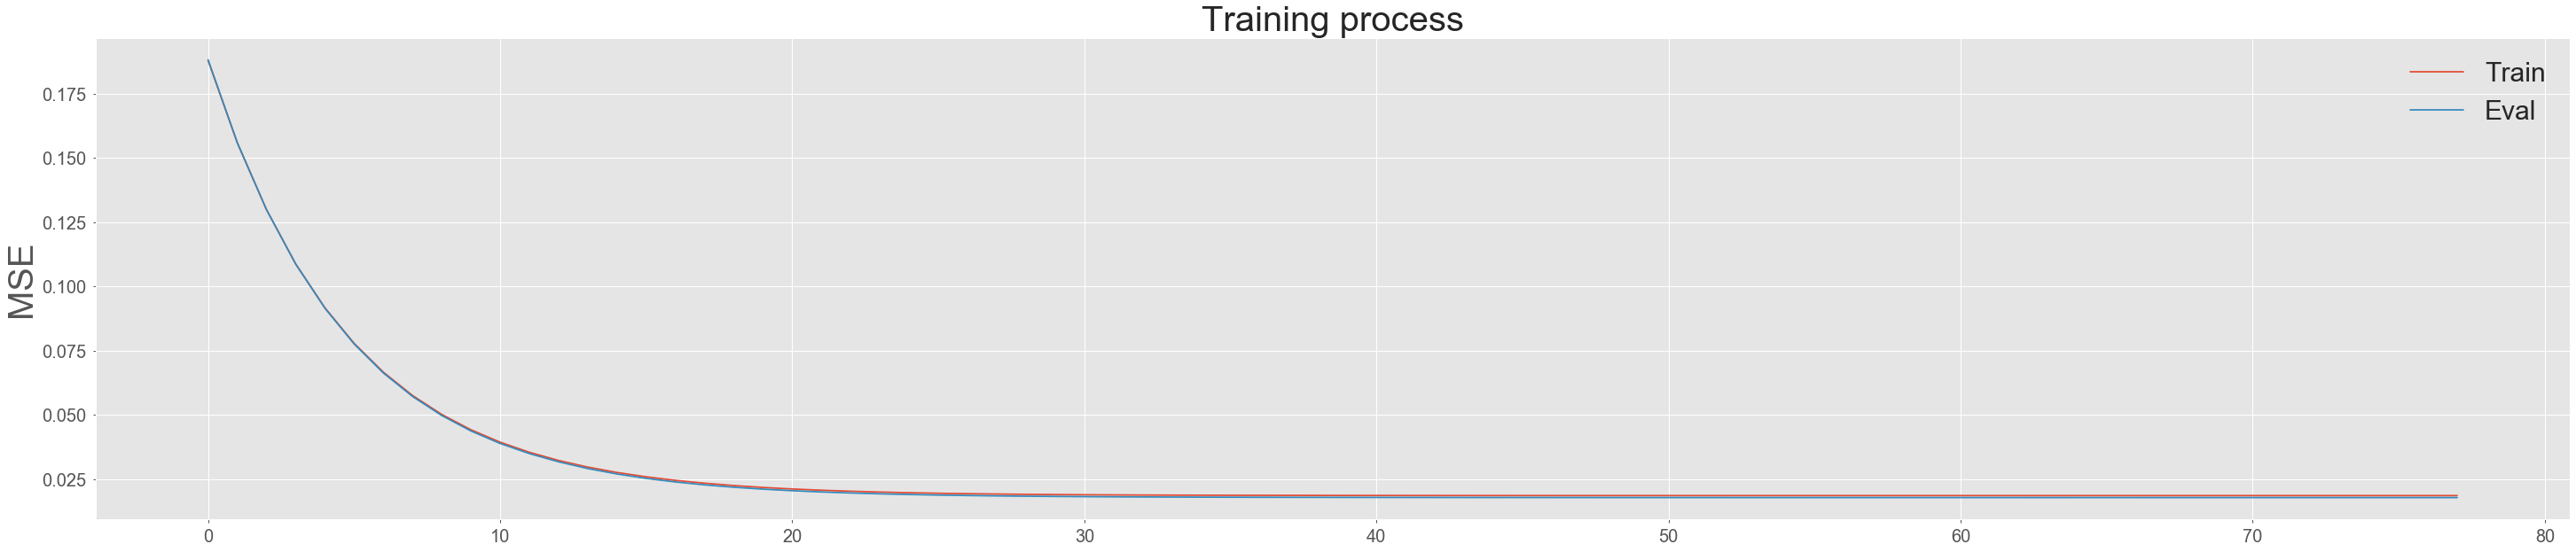

In [422]:
plotter()

In [423]:
model_mse(model_v3, 
          df_v1_train,
          df_v1_eval,
          df_v1,
          cols_lose0)

{'train': 18653, 'eval': 17880, 'overall': 18498}

One can see that the model overfits to the train data set

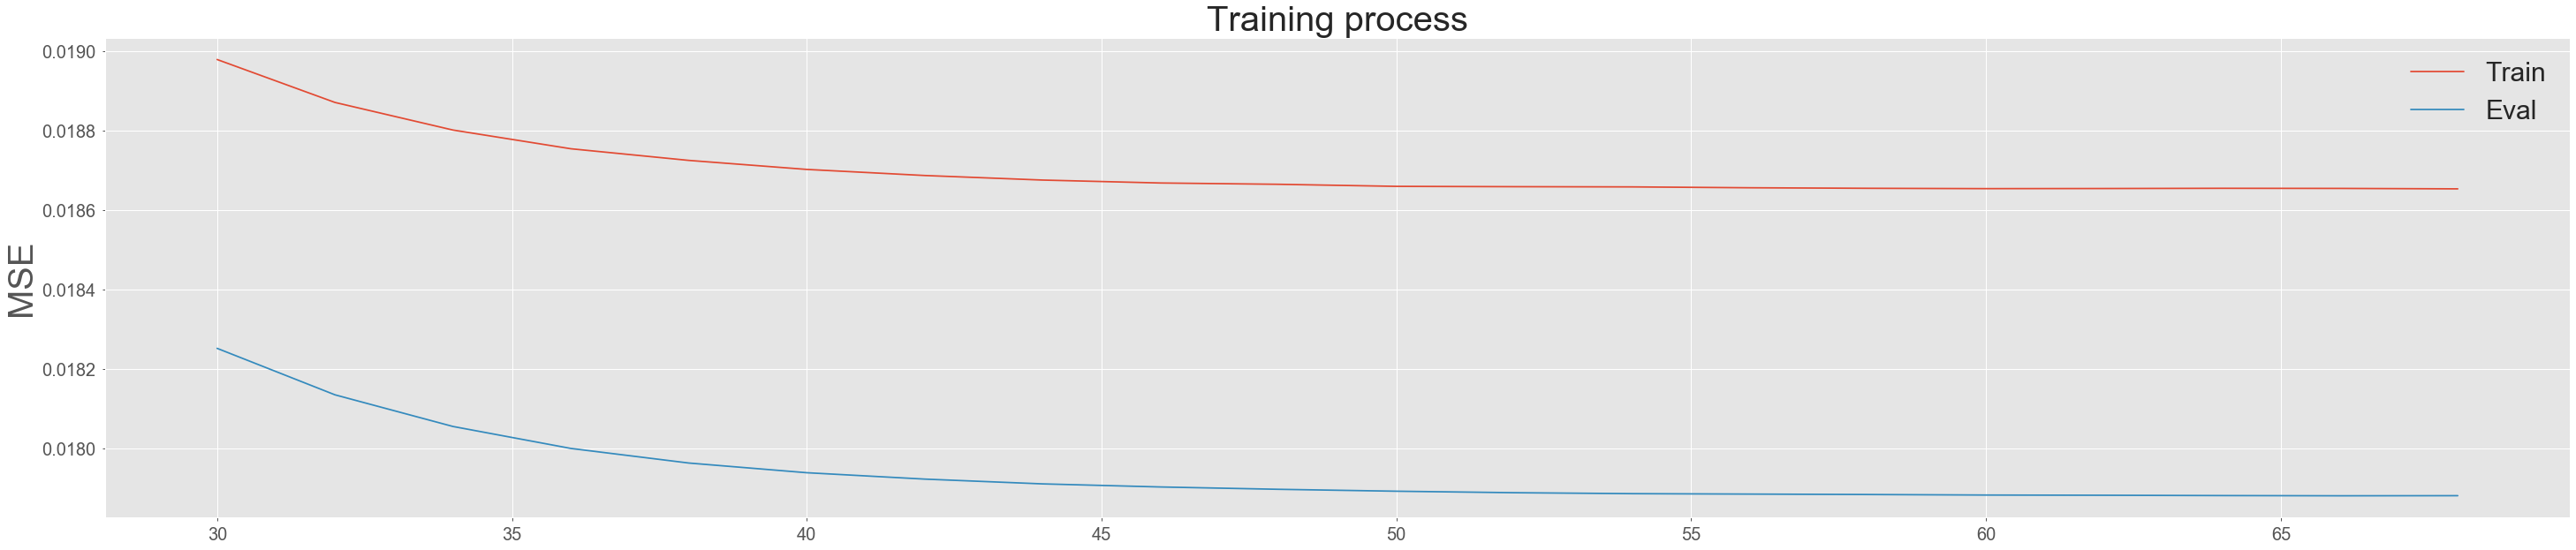

In [425]:
plotter(epochs=[i for i in range(30, 70, 2)])

In [426]:
with open(os.path.join(PATH_MODEL, "v3/model.pkl"), 'wb') as f:
    pickle.dump(model_v3, f)

model_v3 has ~1% performance improvement compared to the model_v2, it is however 2.5 times more complex (would require more storage, disk and RAM space) and would be more computational resources demanding to run prediction.

In [428]:
# let's compare the disk space required be the models

! du -h ${PWD}/../bucket/model/v{1,2,3}/model.pkl

4.0K	/Users/dkisler/projects/sellics_challenge/analytics/../bucket/model/v1/model.pkl
260K	/Users/dkisler/projects/sellics_challenge/analytics/../bucket/model/v2/model.pkl
560K	/Users/dkisler/projects/sellics_challenge/analytics/../bucket/model/v3/model.pkl


## Models performance comparison

In [441]:
baseline_performance0 = {
    "train": baseline_mse(df_v1_train.copy()),
    "eval": baseline_mse(df_v1_eval.copy()),
    "overall": baseline_mse(df_v1.copy())
}

In [453]:
baseline_performance = {}
for k, v in baseline_performance0.items():
    for k1, v1 in v.items():
        if k1 == 'baseline3':
            continue
        if k1 not in baseline_performance:
            baseline_performance[k1] = {} 
        baseline_performance[k1][k] = v[k1]

In [506]:
performance = baseline_performance

for i in [1, 2, 3]:
    model_ver = f"model_v{i}"
    performance[model_ver] = model_mse(eval(model_ver), 
                                       df_v1_train,
                                       df_v1_eval,
                                       df_v1,
                                       cols_lose0)

In [507]:
performance = pd.DataFrame(performance).T
performance['model'] = performance.index
performance.reset_index(drop=True, inplace=True)
performance['overall_impovement_pct'] = round(abs(performance['overall'].diff())/performance['overall'] * 100, 1)

In [508]:
performance

train   eval  overall      model  overall_impovement_pct
0  21253  20008    21004  baseline0                     NaN
1  19349  18240    19127  baseline1                     9.8
2  19252  18110    19025  baseline2                     0.5
3  19031  17941    18813   model_v1                     1.1
4  18712  17949    18559   model_v2                     1.4
5  18653  17880    18498   model_v3                     0.3

A gradual drop of MSE can be seen in the table above, models complexity brings however an under 1% performance improvement. It means that any further MSE drop can be achieved by training on more data (beyond the scope of the problem), or by performing further feature engineering.

## Feature engineering v2

The data set is inbalanced in terms of *CR=0*, or *CR>0*. One can try imploying different data balancing techniques.

## Data classes balancing

The data set is unbalanced with cr = 0 being oversamples "class" of data points. Let's try to balance this out and (re-)train the model using the data sample with balanced data points distribution.

The data sampling/balancing is being according to the following steps:

* select data points with cr>0 as d_positive. size0=len(d_positive)
* randomly subset the data with cr==0 to the size=size0, d_negative
* randomly subset d_positive to the size of alpha*size0
* randomly subset d_negative to the size of alpha*size0
* union(d_positive, d_negative) -> df_balanced
* randomly shuffle df_balanced

*alpha* is a sampling hyper-parameter, it's being set to 0.7

The model is being re-train on balanced data set using several sampling iterations in a loop

In [503]:
from typing import Tuple


def data_balancing(df: pd.DataFrame, 
                   alpha=0.7,
                   random_state=(1, 2)): # -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Function to balance data set
    
    Args:
        df: input data frame
        alpha: balancing paramter
        random_state: tuple of random states to set seed
    
    Returns:
        Tuple of X_train, X_test, y_train, y_test
    """
    d_positive = df[df['cr'] > 0]
    size = int(alpha * len(d_positive))

    d_positive_sub = d_positive.sample(size, 
                                       replace=False, 
                                       random_state=random_state[0])    
    d_negative_sub = df[df['cr'] == 0].sample(size, 
                                              replace=False, 
                                              random_state=random_state[0])
    
    d_combined = pd.concat([d_positive_sub,
                            d_negative_sub],
                           axis=0)\
                   .sample(frac=1, 
                           random_state=random_state[1])\
                   .reset_index(drop=True)

    del d_positive_sub, d_positive, d_negative_sub, size

    X_train, X_test, y_train, y_test = train_test_split(d_combined.drop(['cr'], axis=1), 
                                                        d_combined['cr'], 
                                                        test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=2019)
    return X_train, X_test, y_train, y_test

In [504]:
model_vX.save_model('model_vX.xgb')
for i in range(20):
    X_train, X_test, y_train, y_test = data_balancing(df.drop(['entity_id'], axis=1),
                                                      random_state=(i + 1000, 
                                                                    i + 1100))
    model_vX.fit(X_train, y_train, xgb_model='model_vX.xgb',
                 verbose=False)

    print(f"Test MSE:{MSE(y_test, model_vX.predict(X_test))}")

    print(f"""Overall MSE: {MSE([*y_train, *y_test], 
              [*model_vX.predict(X_train), *model_vX.predict(X_test)])}""")
    model_vX.save_model('model_vX.xgb')

/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.043146173782710844
Overall MSE: 0.039288290041508425


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.036167658416353686
Overall MSE: 0.03956733069463931


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.0370321692241231
Overall MSE: 0.03908652994771216


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04268224785496322
Overall MSE: 0.03911851053155576


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04068786559458662
Overall MSE: 0.03919925401538084


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.040641813165853004
Overall MSE: 0.03896749793934621


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.036929363256433916
Overall MSE: 0.039728319221053035


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04416472492299008
Overall MSE: 0.041608834317317885


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.0390720743578426
Overall MSE: 0.04059072413789333


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.03862647238298842
Overall MSE: 0.04026409435219689


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.041728029932465244
Overall MSE: 0.04063816144642715


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04336262689968847
Overall MSE: 0.03999269745963401


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04154592981154866
Overall MSE: 0.03978756414817428


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04219881465721223
Overall MSE: 0.04055746201258919


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04184842724165538
Overall MSE: 0.03975223557420444


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.042959161841402665
Overall MSE: 0.03972494517502979


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.039327556021955076
Overall MSE: 0.039215906175284476


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.041615090270174834
Overall MSE: 0.03944411963536218


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04681855668279185
Overall MSE: 0.039471069710819394


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KeyboardInterrupt: 